# Training DQNN with PennyLane

## Introduction
This tutorial is based on the paper [Training deep quantum neural networks](https://www.nature.com/articles/s41467-020-14454-2). We implement the DQNN model proposed in the paper with `PennyLane` and `PyTorch` library.

## Used libraries

In [1]:
import pennylane as qml
import numpy as np
from qiskit.quantum_info import random_unitary, random_density_matrix, random_statevector
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.quantum_info.states.quantum_state import QuantumState, Operator

import torch

from tqdm import trange
from torch.utils.tensorboard import SummaryWriter

## DQNN model class

The unitraies used for each layer is [qml.ArbitraryUnitary](https://docs.pennylane.ai/en/stable/code/api/pennylane.ArbitraryUnitary.html) which is a parametrized unitary. The number of parameters is $4^{m+n}-1$ where $m$ is the number of input qubits and $n$ is the number of output qubits. Unitraries update rule (backprob) in the [paper](https://www.nature.com/articles/s41467-020-14454-2) has not yet been implemented. Family of Gradient descent algorithms such as ADAM can be used instead.

In [2]:
class DQNN(object):

    def __init__(self, qnnArch:list, device_name:str='default.mixed', interface:str='torch'):
        """ Deep Quantum Neural Network 
        Args:
            qnnArch: list of integers representing the architecture of the DQNN. e.g. [2, 3, 2] represents 2q input, 3q hidden, 2q output
            device_name: name of the PennyLane device to use. Currently, only 'default.mixed' is supported
            interface: interface to use for the PennyLane device. Currently, only 'torch' is considered
        """
        self.qnnArch = qnnArch
        self.device_name = device_name
        self.interface = interface

    def makeRandomUnitaries(self, seed:int=None): # TODO: seed does nothing yet
        """ Randomly initialize unitary parameters """
        unitaries = []
        for l in range(len(self.qnnArch)-1):
            unitaries.append([])
            unitaries[l] = torch.randn(self.qnnArch[l+1], 4**(self.qnnArch[l]+1)-1, requires_grad=True)
        return unitaries

    def applyLayerChannel(self, unitaries:list, l:int, inputState):
        numInputQubits = self.qnnArch[l]
        numOutputQubits = self.qnnArch[l+1]
        inputWires = list(range(numInputQubits))
        outputWires = list(range(numInputQubits, numInputQubits+numOutputQubits))
        layerUnitaries = unitaries[l]
        # type check
        if isinstance(inputState, QuantumState) or len(inputState.shape) == 1:
            inputState = torch.tensor(DensityMatrix(inputState).data, requires_grad=False)
        for _ in outputWires:
            inputState = torch.kron(inputState, torch.tensor([[1, 0], [0, 0]], dtype=torch.complex128))

        @qml.qnode(device=qml.device(name=self.device_name, wires=numInputQubits+numOutputQubits), interface=self.interface)
        def layerChannel(inputState):
            qml.QubitDensityMatrix(inputState, wires=inputWires+outputWires)
            for j in range(numOutputQubits):
                qml.ArbitraryUnitary(weights=layerUnitaries[j], wires=inputWires+[outputWires[j]])
            return qml.density_matrix(wires=outputWires)

        return layerChannel(inputState)

    def forward(self, unitaries, inputs):
        """ Forward pass of the DQNN
        Args:
            unitaries: list of unitary parameters per layer
            inputs: tensor of input states of shape (batch_size, input_dim, input_dim)

        Returns: 
            outputs: tensor of output states of shape (batch_size, output_dim, output_dim)
        """
        outputs = []
        for inputState in inputs:
            for l in range(len(self.qnnArch)-1):
                inputState = self.applyLayerChannel(unitaries, l, inputState)
            outputs.append(inputState)
        return torch.stack(outputs)
    

## Data preparation & Cost functions

Training data $\vert \psi_{in} \rangle$ is sampled from Haar measure using `qiskit.quantum_info.random_statevector`. The type of training data is therefore `qiskit.quantum_info.Statevector`. The target data $\vert \psi_{out} \rangle$ is generated with arbitrary $V$, s.t. $\vert \psi_{out} \rangle=V\vert \psi_{in} \rangle$. However, to match with the DQNN forward output, the type of target data is `torch.tensor`. The cost function is defined as the average fidelity between the output state $\vert \psi_{out} \rangle$ and the model output $\rho_{out}$: $C = \frac{1}{N}\sum_{i=1}^{N} \langle \psi_{out}^{(i)} \vert \rho_{out}^{(i)} \vert \psi_{out}^{(i)} \rangle$.

In [3]:
def generate_random_training_data(numSamples:int, numInputQubits:int):
    """ Generate random training data 
    Args:
        numSamples: number of samples to generate
        numInputQubits: number of input qubits
    Returns:
        trainingData: list of random input states
    """
    trainingData = []
    for i in range(numSamples):
        trainingData.append(
            random_statevector(2**numInputQubits, seed=None) # TODO: seed
        )
    return trainingData

def generate_target_from_unitary(unitary:Operator, trainingData:list):
    """ Generate target states from a unitary
    Args:
        unitary: unitary to apply to the training data
        trainingData: list of input states
    Returns:
        targets: list of target states
    """
    targetStates = []
    for inputState in trainingData:
        targetStates.append(
            inputState.evolve(unitary).data
        )
    targetStates = np.array(targetStates)
    return torch.tensor(targetStates, requires_grad=False)

def cost(outputs, targets):
    """ Cost function to maximize
    Args:
        outputs: output states of the DQNN of shape (batch_size, output_dim, output_dim)
        targets: target states of shape (batch_size, output_dim)
    Returns:
        loss: average fidelity between output and target states
    """
    assert len(outputs) == len(targets), "outputs and targets must have the same length"
    loss = 0
    for output, target in zip(outputs, targets):
        loss += torch.real(torch.vdot(target, output @ target))
    return loss/len(outputs)

## Training

The training is done with `torch.optim.Adam` optimizer with learning rate 0.01. DQNN model architecture is [2, 3, 2]. The training is done for 100 epochs. The training fidelity is plotted for each epoch.

In [4]:
unitary = random_unitary(2**2)
model = DQNN([2, 3, 2])
unitaries = model.makeRandomUnitaries()
trainingData = generate_random_training_data(10, 2)
targetStates = generate_target_from_unitary(unitary, trainingData)


optimizer = torch.optim.Adam(unitaries, lr=0.01)

def closure():
    optimizer.zero_grad()
    outputs = model.forward(unitaries, trainingData)
    loss = 1-cost(outputs, targetStates)
    loss.backward()
    return loss

loss_list = []
writer = SummaryWriter(log_dir='./runs/DQNN')
for s in trange(100):
    loss = optimizer.step(closure)
    writer.add_scalar('Loss', loss.item(), s)
    loss_list.append(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]/home/quic/anaconda/envs/qamp/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
100%|██████████| 100/100 [31:29<00:00, 18.89s/it]


Text(0, 0.5, 'Cost/Fidelity')

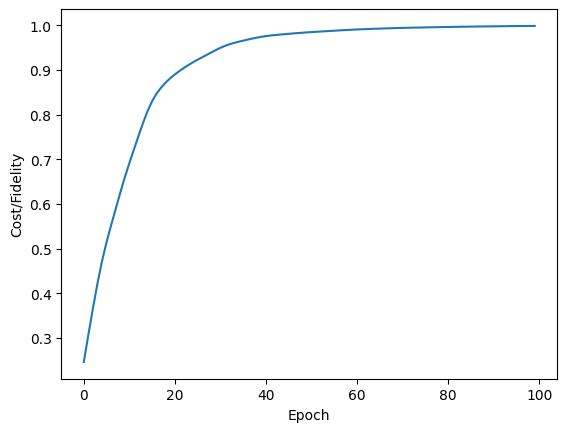

In [5]:
from matplotlib import pyplot as plt
plt.plot(1-np.array(loss_list))
plt.xlabel('Epoch')
plt.ylabel('Cost/Fidelity')

## Conclusion

Although trained fidelity is very high(>99.99%), without backpropagation proposed in the [paper](https://www.nature.com/articles/s41467-020-14454-2), the convergence is not as goood as that in the paper. Compare results of <https://github.com/qigitphannover/DeepQuantumNeuralNetworks/blob/master/DQNN_basic.ipynb>

## Version

In [7]:
qml.version()

'0.26.0'

In [8]:
torch.__version__

'1.12.1'

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table